In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels
from statsmodels.tsa.stattools import adfuller

import sys
sys.path.append("..")

import financial_machine_learning.features.fractional_differencing as fd

In [2]:
data = yf.download("SPY", start="2000-01-01")
data["Returns"] = data["Adj Close"].pct_change()
data["Log Returns"] = np.log(1 + data["Returns"])
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


# Stationary
Issue: With differencing, memory is lost. Is it possible to make the data stationary without losing as much memory?

In [3]:
def print_adfuller(series):
    adftest=adfuller(series)
    print(f"ADF Statistic: {adftest[0]}")
    print(f"ADF p-value: {adftest[1]}")

ADF Statistic: 1.3097461925643756
ADF p-value: 0.9966629518751998


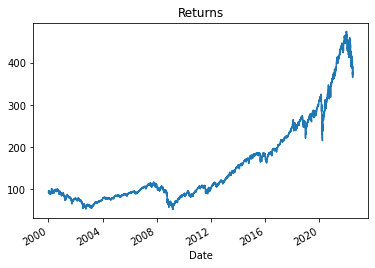

In [4]:
data["Adj Close"].plot(title="Returns")
print_adfuller(data["Adj Close"])

ADF Statistic: 0.4508959190310954
ADF p-value: 0.9833016737144572


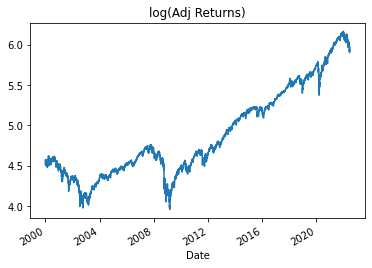

In [5]:
np.log(data["Adj Close"]).plot(title="log(Adj Returns)")
print_adfuller(np.log(data["Adj Close"]))

Stationarity of Returns:
ADF Statistic: -18.511216592329635
ADF p-value: 2.1144276104867864e-30


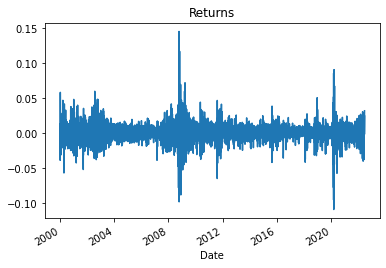

Stationarity of Log Returns:
ADF Statistic: -18.219377871693908
ADF p-value: 2.3819361315561417e-30


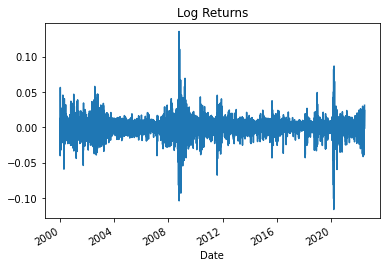

In [6]:
for col in ["Returns", "Log Returns"]:
    print(f"Stationarity of {col}:")
    print_adfuller(data[col])
    data[col].plot(title=col)
    plt.show()


# Fractional Differencing

[This Wikipedia section](https://en.wikipedia.org/wiki/Autoregressive_fractionally_integrated_moving_average#Basics) shows how the backshift operator works for ARIMA models. For an `Arima(p,d,q)` model `d` is an integer. With `p=0, q=0`the model becomes `(1-B)^d X_t = eps_t` where `eps_t` is white noise. One can generalize that eqation fractional values of `d` and use the binomial series expansion such that `(1-B)^d = w_0 + w_1*B + w_2*B^2 + ...` for some weights `w_i`.

When calculating returns with `d=1`, one uses the lag operator with `w_0=1, w_1=-1 and w_k=0 for k>1`

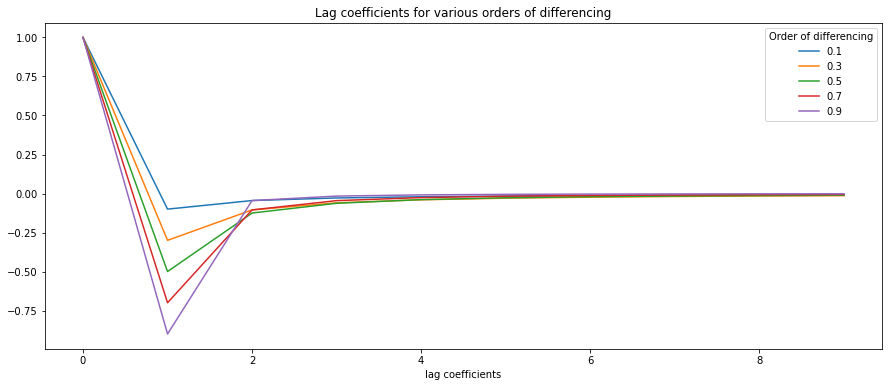

In [7]:
fd.plot_weights([0.1,0.9], 10, 5)

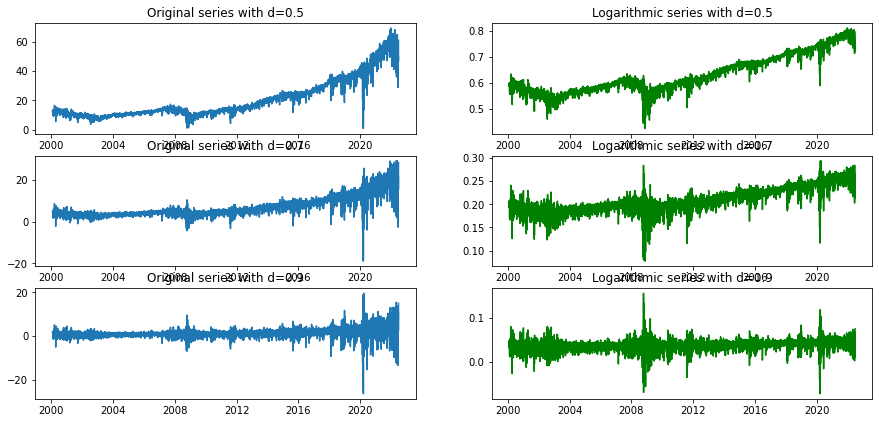

In [8]:
differences=[0.5, 0.7, 0.9]
fig, axs = plt.subplots(len(differences), 2, figsize=(15, 6))
for i in range(0,len(differences)):
    axs[i, 0].plot(fd.differencing(data["Adj Close"], differences[i], 20))
    axs[i, 0].set_title("Original series with d=" + str(differences[i]))
    axs[i, 1].plot(fd.differencing(np.log(data["Adj Close"]), differences[i], 20), "g-")
    axs[i ,1].set_title("Logarithmic series with d=" + str(differences[i]))
    plt.subplots_adjust(bottom=0.01) # increasing space between plots for aestethics

In [9]:
possible_d = np.divide(range(1, 100), 100)
tau = 1e-4

adf_val = [None] * len(possible_d)
adf_val_log = [None] * len(possible_d)
adf_p = [None] * len(possible_d)
adf_p_log = [None] * len(possible_d)
corr = [None] * len(possible_d)
corr_log = [None] * len(possible_d)

for i in tqdm(range(len(possible_d))):
    diff = fd.differencing_tau(data["Adj Close"], possible_d[i], tau)
    diff_log = fd.differencing_tau(np.log(data["Adj Close"]), possible_d[i], tau)

    adf_val[i] = adfuller(diff)[0]
    adf_val_log[i] = adfuller(diff_log)[0]

    adf_p[i] = adfuller(diff)[1]
    adf_p_log[i] = adfuller(diff_log)[1]

    corr[i] = np.corrcoef(data["Adj Close"].loc[diff.index], diff)[0][1]
    corr_log[i] = np.corrcoef(np.log(data["Adj Close"].loc[diff.index]), diff)[0][1]

100%|██████████| 99/99 [00:56<00:00,  1.76it/s]


Text(0.5, 1.0, 'ADF P-value by differencing order in the logarithmic series')

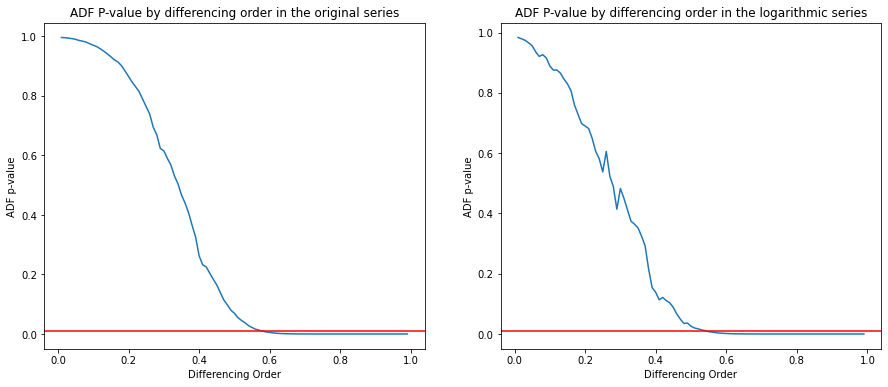

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].plot(possible_d, adf_p)
axs[0].set_xlabel("Differencing Order")
axs[0].set_ylabel("ADF p-value")
axs[0].axhline(y=0.01,color="r")
axs[0].set_title("ADF P-value by differencing order in the original series")

axs[1].plot(possible_d, adf_p_log)
axs[1].set_xlabel("Differencing Order")
axs[1].set_ylabel("ADF p-value")
axs[1].axhline(y=0.01,color="r")
axs[1].set_title("ADF P-value by differencing order in the logarithmic series")

Text(0.5, 0.98, 'One can keep some correlation with differencing less and still have a stationary time series')

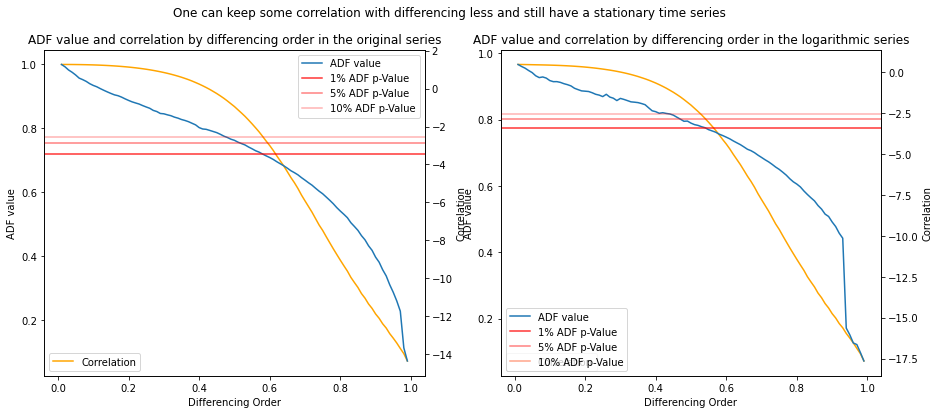

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].plot(possible_d, corr, label = "Correlation", c="orange")
axs02 = axs[0].twinx()
axs02.plot(possible_d, adf_val, label = "ADF value")
axs[0].set_xlabel("Differencing Order")
axs[0].set_ylabel("ADF value")
axs02.set_ylabel("Correlation")
axs02.axhline(y=fd.CRITICAL_VALUES["1%"], color="r", label="1% ADF p-Value", alpha = 0.8)
axs02.axhline(y=fd.CRITICAL_VALUES["5%"], color="r", label="5% ADF p-Value", alpha = 0.5)
axs02.axhline(y=fd.CRITICAL_VALUES["10%"], color="r", label="10% ADF p-Value", alpha = 0.3)
axs[0].set_title("ADF value and correlation by differencing order in the original series")
axs02.legend()
axs[0].legend(loc=3)


axs[1].plot(possible_d, corr_log, label = "Correlation", c="orange")
axs12 = axs[1].twinx()
axs12.plot(possible_d, adf_val_log, label = "ADF value")
axs[1].set_xlabel("Differencing Order")
axs[1].set_ylabel("ADF value")
axs12.set_ylabel("Correlation")
axs12.axhline(y=fd.CRITICAL_VALUES["1%"], color="r", label="1% ADF p-Value", alpha = 0.8)
axs12.axhline(y=fd.CRITICAL_VALUES["5%"], color="r", label="5% ADF p-Value", alpha = 0.5)
axs12.axhline(y=fd.CRITICAL_VALUES["10%"], color="r", label="10% ADF p-Value", alpha = 0.3)
axs[1].set_title("ADF value and correlation by differencing order in the logarithmic series")
axs12.legend()
axs[1].legend(loc=3)

fig.suptitle("One can keep some correlation with differencing less and still have a stationary time series")